# Building Nonlinear Core Correction (NLCC) as a gaussian

NLCC as a Gaussian with sigma = 1.2 / Units.Bohr

In [1]:
import sys, os
sys.path.append(os.path.abspath('/projectsn/mp1009_1/Valeria/NLPP_high_temperature/PStudio/'))
import numpy as np
import matplotlib.pyplot as plt
from dftpy.field import DirectField
from dftpy.formats import io
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from pstudio.oncvpsp_routines.oncvpsp import hartree
from dftpy.optimization import Optimization
from dftpy.ions import Ions
from dftpy.grid import DirectGrid
from dftpy.math_utils import ecut2nr
from ase import Atoms
from dftpy.math_utils import ecut2nr

In [2]:
from dftpy.functional import LocalPseudo, Functional, TotalFunctional

In [3]:
ions_ag, rho_target_ag, _ = io.read_all('/projectsn/mp1009_1/Valeria/NLPP/All_elements/rho_ref/rho_Ag_gbrv.xsf')
grid = rho_target_ag.grid

path_ngbrv = '/projectsn/mp1009_1/Valeria/NLPP/NPP_0.2/'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_gbrv_new.psp8'}

path_gbrv = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
PP_list_gbrv_ag = {'Ag': path_gbrv+'ag_lda_v1.4.uspp.F.UPF'}

nr = ecut2nr(ecut=600, lattice=ions_ag.cell)
grid = DirectGrid(lattice=ions_ag.cell, nr=nr)

pseudo_gbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_gbrv_ag)
pseudo_gbrv_ag.local_PP()
v_gbrv_ag = pseudo_gbrv_ag.readpp.pp['Ag'].v

pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
pseudo_ngbrv_ag.local_PP()
v_ngbrv_ag = pseudo_ngbrv_ag.readpp.pp['Ag'].v

setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/PP/ag_lda_v1.4.uspp.F.UPF
setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/NPP_0.2//Ag_gbrv_new.psp8


##  Build Nonlinear Core Correction

In [4]:
from dftpy.field import ReciprocalField, DirectField
from scipy.signal import gauss_spline
def build_core_density_gaussian(r, r0, scaling=1.0):
    sigma = r0 / 2 
    # r = grid.rr
    r = r
    n = 12 * sigma - 1
    print(n)
    gaussian = scaling * gauss_spline(r, n)
    return gaussian

In [5]:
core_density_gbrv_r = pseudo_gbrv_ag.readpp.pp['Ag'].core_density
v_gbrv_ag = pseudo_gbrv_ag.readpp.pp['Ag'].v
r_gbrv = pseudo_gbrv_ag.readpp.pp['Ag'].r
r_core = pseudo_gbrv_ag.readpp.pp['Ag'].core_density_grid
core_density_gbrv = pseudo_gbrv_ag.core_density

In [6]:
from dftpy.constants import Units

In [7]:
sigma = 1.2 / Units.Bohr # Angs to Bohrs

In [8]:
core_g = build_core_density_gaussian(r_gbrv, sigma, 1)

12.606028106025885


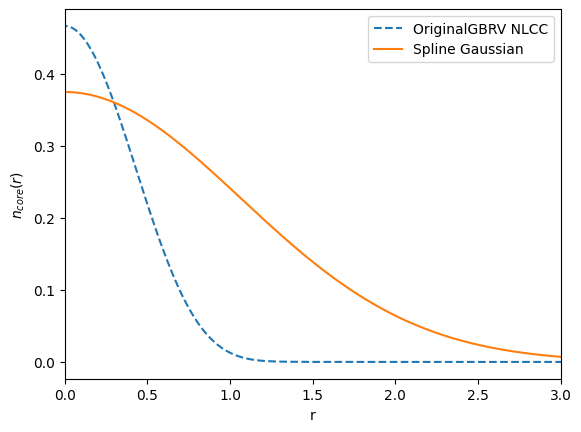

In [9]:
plt.plot(r_gbrv, core_density_gbrv_r, '--', label='OriginalGBRV NLCC')
plt.plot(r_core, core_g, label='Spline Gaussian')
plt.ylabel(r'$n_{core}(r)$')
plt.xlabel('r')
plt.xlim(0,3)
plt.legend()

##### Save the pseudopotential with the NLCC

In [10]:
path_ngbrv = '/projectsn/mp1009_1/Valeria/NLPP/NPP_0.2/'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_gbrv_new.psp8'}

key = 'Ag'
r = pseudo_ngbrv_ag.readpp.pp[key].r
vl = pseudo_ngbrv_ag.readpp.pp[key].v
zval = pseudo_ngbrv_ag.zval[key]

from dftpy.functional.pseudo.psp import PSP
engine = PSP(None)
engine.r = r
engine.v = vl
engine.info['atomicnum'] = 27
engine.info['fchrg'] = 1.0
engine.info['mmax'] = len(r)
engine._zval = zval
engine._core_density_grid = r
engine._core_density = core_g * 4 * np.pi # Multiplying by 4*np.pi to write in psp8 format
engine.write('Ag_nlcc_smooth_gbrv.psp8')

In [11]:
path_ngbrv = './'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_nlcc_smooth_gbrv.psp8'}

##### Read the saved pseudopotential with the NLCC

In [12]:
pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
pseudo_ngbrv_ag.local_PP()
core_density_nlcc = pseudo_ngbrv_ag.core_density ### Get the core density on a grid (in this case the grid for the FCC Ag)

v_ngbrv_ag = pseudo_ngbrv_ag.readpp.pp['Ag'].v
r_ngbrv = pseudo_ngbrv_ag.readpp.pp['Ag'].r

core_density_ngbrv = pseudo_ngbrv_ag.readpp.pp['Ag'].core_density ### Get the core density on r
r_core = pseudo_ngbrv_ag.readpp.pp['Ag'].core_density_grid

setting key: Ag -> .//Ag_nlcc_smooth_gbrv.psp8


##### Visualize the core density from GBRV and NGBRV as well as the LPP

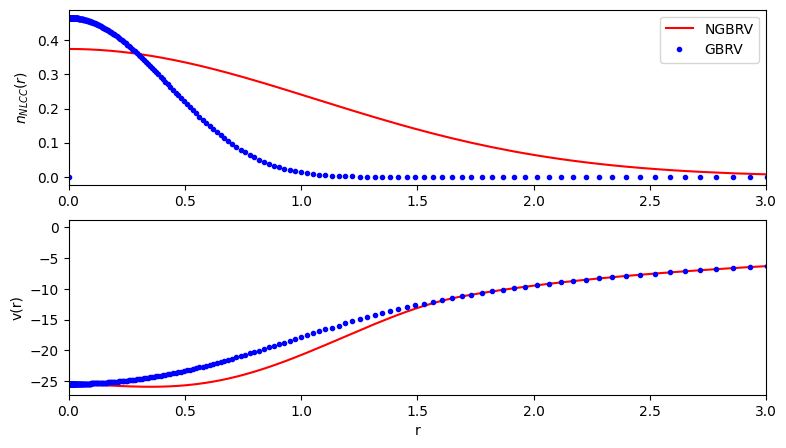

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9,5))
axs[0].plot(r_ngbrv, (core_density_ngbrv).ravel(), 'r', label='NGBRV')
axs[0].plot(r_gbrv, core_density_gbrv_r.ravel(), 'b.', label='GBRV')

axs[1].plot(r_ngbrv, (v_ngbrv_ag).ravel(), 'r')
axs[1].plot(r_gbrv, v_gbrv_ag.ravel(), 'b.')

axs[0].set_ylabel(r'$n_{NLCC}(r)$')
axs[1].set_ylabel('v(r)')
axs[1].set_xlabel('r')

axs[0].set_xlim(0.0,3)
axs[1].set_xlim(0.0,3)
axs[0].legend()

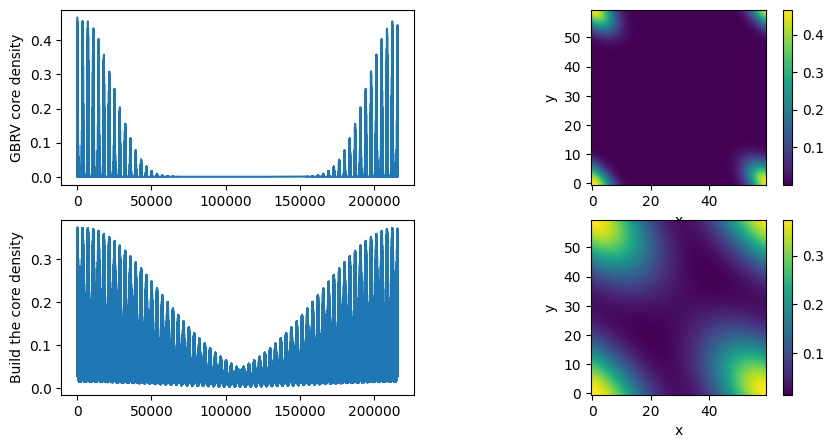

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
axs[0,0].plot(core_density_gbrv.ravel())

z_slice = core_density_gbrv.shape[2] // 2
z_slice = 0
im1 = axs[0,1].imshow(core_density_gbrv[:, :, z_slice], origin='lower', cmap='viridis')
fig.colorbar(im1, ax=axs[0,1], orientation='vertical')

axs[0,1].set_xlabel("x")
axs[0,1].set_ylabel("y")
axs[0,0].set_ylabel("GBRV core density")
axs[1,0].plot((core_density_nlcc).ravel())
im2=axs[1,1].imshow((core_density_nlcc)[:, :, z_slice], origin='lower', cmap='viridis')
fig.colorbar(im2, ax=axs[1,1], orientation='vertical')

# axs[1].colorbar(label="ρ_core")
# axs[1,1].set_title("Midplane Slice of NLCC Field (z = center)")
axs[1,1].set_xlabel("x")
axs[1,1].set_ylabel("y")
axs[1,0].set_ylabel("Build the core density")
plt.show()

#### Analysis in reciprocal space

In [16]:
grid = core_density_nlcc.grid
grid = DirectGrid(lattice=ions_ag.cell, nr=nr)
pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
core_density = pseudo_ngbrv_ag.core_density

reciprocal_grid = grid.get_reciprocal()
g = reciprocal_grid.g
rhog = core_density.fft()
new_rhog = ReciprocalField(grid=grid, griddata_3d=rhog[:])

setting key: Ag -> .//Ag_nlcc_smooth_gbrv.psp8


In [17]:
new_rhor = new_rhog.ifft()

/projectsn/mp1009_1/Valeria/qms2024/.dftpy/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/projectsn/mp1009_1/Valeria/qms2024/.dftpy/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


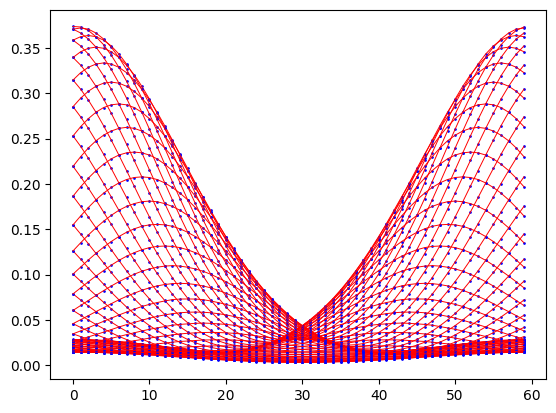

In [18]:
for i in np.arange(0,len(g[0][0])):
    plt.plot(core_density[i,i,:].ravel(), 'b.', markersize=1.9)
    plt.plot(new_rhor[i,i,:].ravel(), 'r', lw=0.7)

In [19]:
def get_energy(KE, ions, PSEUDO):
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                       optimization_method = 'CG')
    rho = opt.optimize_rho(guess_rho=rho_ini)
    forces = evaluator.get_forces(rho=rho)
    v = KE(rho).potential
    return evaluator.Energy(rho=rho, ions=ions), rho, forces, evaluator

In [20]:
HARTREE = Functional(type='HARTREE')
opt_options = {'econv' : 1e-6}

### Analysis of analytical vs numerical forces and energy vs distance

In [21]:
import numpy as np
from dftpy.functional import TotalFunctional
from dftpy.optimization import Optimization
from copy import deepcopy

def compute_numerical_forces(ions, energy_evaluator, dr=1e-2):
    n_atoms = ions.nat
    forces = np.zeros((n_atoms, 3))
    positions0 = ions.positions.copy()

    for i in range(n_atoms):
        for j in range(3):
            ions_plus = deepcopy(ions)
            ions_plus.positions[i, j] += dr
            PSEUDO = LocalPseudo(grid = grid, ions=ions_plus, PP_list=PP_list_ngbrv_ag)
            eval_plus = TotalFunctional(KE=energy_evaluator.KE,
                                         XC=energy_evaluator.XC,
                                         HARTREE=energy_evaluator.HARTREE,
                                         PSEUDO=PSEUDO)
            eval_plus.ions = ions_plus
            rho_ini = DirectField(grid=grid)
            rho_ini[:] = ions_plus.get_ncharges()/ions_plus.cell.volume
            opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                   optimization_method = 'CG')
            rho_plus = opt.optimize_rho(guess_rho=rho_ini)
            E_plus = eval_plus.Energy(rho_plus)
            
            ions_minus = deepcopy(ions)
            ions_minus.positions[i, j] -= dr
            PSEUDO = LocalPseudo(grid = grid, ions=ions_minus, PP_list=PP_list_ngbrv_ag)
            eval_minus = TotalFunctional(KE=energy_evaluator.KE,
                                          XC=energy_evaluator.XC,
                                          HARTREE=energy_evaluator.HARTREE,
                                          PSEUDO=PSEUDO)
            eval_minus.ions = ions_minus
            rho_ini = DirectField(grid=grid)
            rho_ini[:] = ions_minus.get_ncharges()/ions_minus.cell.volume
            opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                   optimization_method = 'CG')
            rho_minus = opt.optimize_rho(guess_rho=rho_ini)
            E_minus = eval_minus.Energy(rho_minus)
            E_minus = eval_minus.Energy(rho_minus)

            forces[i, j] = -(E_plus - E_minus) / (2 * dr)

    ions.positions[:] = positions0
    return forces


#### NGBRV0.2 with NLCC

In [22]:
path_ngbrv = './'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_nlcc_smooth_gbrv.psp8'}

In [23]:
from ase import Atoms
E_ngbrv_f = []
F_ngbrv_f = []
F_num = []
V = []

opt_options = {'econv' : 1e-4}
# alats_n = np.linspace(0, 1.5, 10)
alats = [1.0, 1.2, 1.4, 1.6]#, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]#, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]
L = 10
for alat in alats:
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    ions = Ions.from_ase(atoms)
    grid = DirectGrid(lattice=ions.cell, ecut=50)
    print(grid.spacings[0], grid.nr)
    PSEUDO_nGBRV = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv_ag)
    core = PSEUDO_nGBRV.core_density
    # PSEUDO_nGBRV.local_PP()
    XC = Functional(type='XC',name='LDA', core_density=core, pseudo=PSEUDO_nGBRV, libxc=False)
    KE = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core)
    ene_ngbrv, rho, forces, evaluator = get_energy(KE, ions, PSEUDO_nGBRV)
    forces_num = compute_numerical_forces(ions, evaluator)
    F_num.append(forces_num)
    F_ngbrv_f.append(forces)
    E_ngbrv_f.append(ene_ngbrv)

0.3149543543061547 [60 60 60]
setting key: Ag -> .//Ag_nlcc_smooth_gbrv.psp8
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.772219487060E+01      8.772219E+01    1.791909E+02    1       1       1.028385E-01    
1       -2.245869205536E+02     -3.123091E+02   7.008378E+02    1       4       3.033273E-01    
2       -2.297187188645E+02     -5.131798E+00   1.443749E+03    1       1       3.600767E-01    
3       -2.800787488179E+02     -5.036003E+01   9.764227E+01    1       2       4.644177E-01    
4       -2.843433318088E+02     -4.264583E+00   5.362300E+01    1       3       7.030079E-01    
5       -2.891341680373E+02     -4.790836E+00   1.629129E+01    1       3       9.476259E-01    
6       -2.906893896616E+02     -1.555222E+00   9.959721E+00    1       3       1.216563E+00    
7       -2.914660221379E+02     -7.766325E-01   4.450126E+00    1       3       1.387929E+00    
8       -2.920185414932E+02     -5.525194E-01   3.

In [24]:
atom1_x_num = [F_num[0][0][0], F_num[1][0][0], F_num[2][0][0], F_num[3][0][0]]
atom1_x_anl = [F_ngbrv_f[0][0][0], F_ngbrv_f[1][0][0], F_ngbrv_f[2][0][0], F_ngbrv_f[3][0][0]]

atom2_x_num = [F_num[0][1][0], F_num[1][1][0], F_num[2][1][0], F_num[3][1][0]]
atom2_x_anl = [F_ngbrv_f[0][1][0], F_ngbrv_f[1][1][0], F_ngbrv_f[2][1][0], F_ngbrv_f[3][1][0]]

atom1_y_num = [F_num[0][0][1], F_num[1][0][1], F_num[2][0][1], F_num[3][0][1]]
atom1_y_anl = [F_ngbrv_f[0][0][1], F_ngbrv_f[1][0][1], F_ngbrv_f[2][0][1], F_ngbrv_f[3][0][1]]

atom2_y_num = [F_num[0][1][1], F_num[1][1][1], F_num[2][1][1], F_num[3][1][1]]
atom2_y_anl = [F_ngbrv_f[0][1][1], F_ngbrv_f[1][1][1], F_ngbrv_f[2][1][1], F_ngbrv_f[3][1][1]]

atom1_z_num = [F_num[0][0][2], F_num[1][0][2], F_num[2][0][2], F_num[3][0][2]]
atom1_z_anl = [F_ngbrv_f[0][0][2], F_ngbrv_f[1][0][2], F_ngbrv_f[2][0][2], F_ngbrv_f[3][0][2]]

atom2_z_num = [F_num[0][1][2], F_num[1][1][2], F_num[2][1][2], F_num[3][1][2]]
atom2_z_anl = [F_ngbrv_f[0][1][2], F_ngbrv_f[1][1][2], F_ngbrv_f[2][1][2], F_ngbrv_f[3][1][2]]

/tmp/ipykernel_53343/641521610.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0,1].legend()


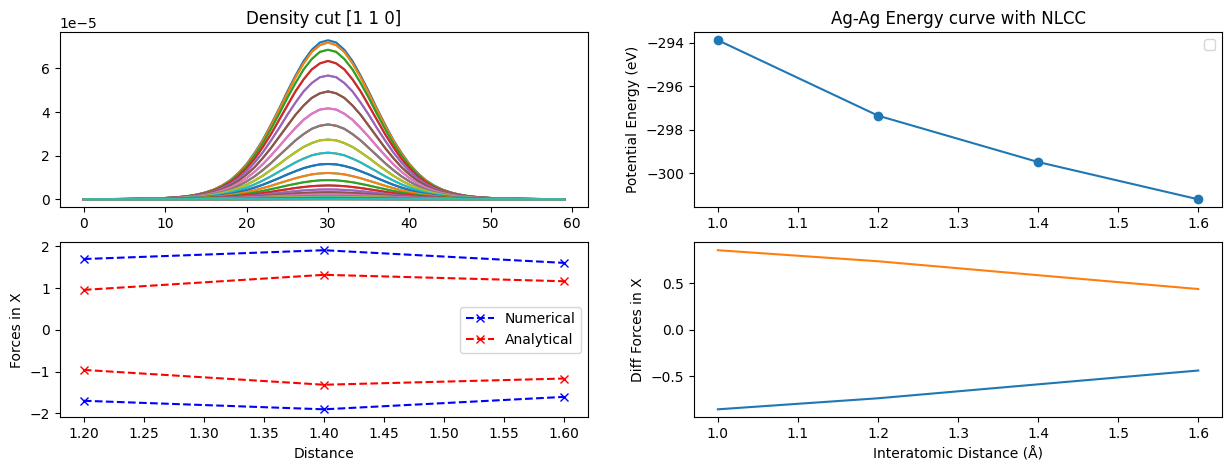

In [25]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,5))

for i in np.arange(len(rho[0][0])):
    axs[0,0].plot((rho)[0,i,:].ravel())
    
axs[0,1].scatter(alats[0:],  np.asarray(E_ngbrv_f[0:]))
axs[0,1].plot(alats[0:],  np.asarray(E_ngbrv_f[0:]))

axs[1,0].plot(alats[1:], atom1_x_num[1:], '--', label='Numerical', marker='x', color='b')
axs[1,0].plot(alats[1:], atom1_x_anl[1:], '--', label='Analytical', marker='x', color='r')
axs[1,0].set_ylabel('Forces in X')
axs[1,0].set_xlabel('Distance')
axs[1,0].plot(alats[1:], atom2_x_num[1:], '--', marker='x', color='b')
axs[1,0].plot(alats[1:], atom2_x_anl[1:], '--',  marker='x', color='r')
axs[1,0].legend()
axs[1,1].plot(alats, np.asarray(atom1_x_num)-np.asarray(atom1_x_anl))
axs[1,1].plot(alats, np.asarray(atom2_x_num)-np.asarray(atom2_x_anl))
axs[1,1].set_ylabel('Diff Forces in X')
axs[1,1].set_xlabel('Distance')

plt.xlabel('Interatomic Distance (Å)')
axs[0,1].set_ylabel('Potential Energy (eV)')
axs[0,0].set_title('Density cut [1 1 0]')
axs[0,1].set_title('Ag-Ag Energy curve with NLCC')
# axs[1].set_ylim(-316,-314)


axs[0,1].legend()
plt.show()

### Plot total forces on each direction X, Y and Z

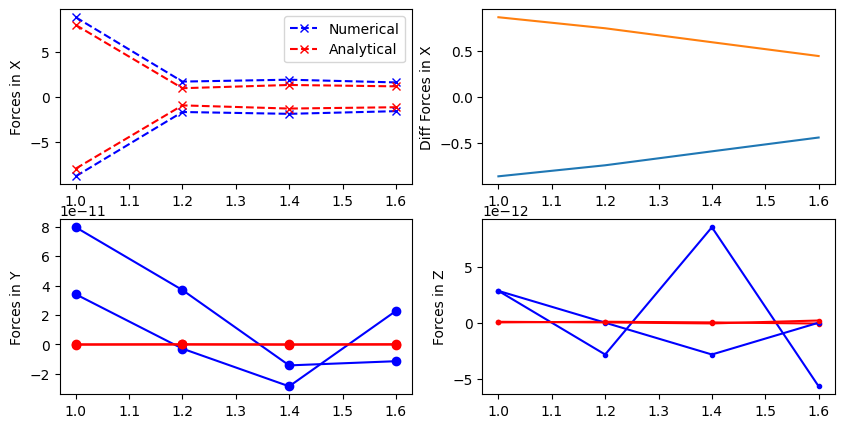

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
axs[0,0].plot(alats, atom1_x_num, '--', label='Numerical', marker='x', color='b')
axs[0,0].plot(alats, atom1_x_anl, '--', label='Analytical', marker='x', color='r')
axs[0,0].set_ylabel('Forces in X')
axs[0,0].plot(alats, atom2_x_num, '--', marker='x', color='b')
axs[0,0].plot(alats, atom2_x_anl, '--',  marker='x', color='r')

# axs[0,1].plot(alats, np.asarray(atom1_x_num)-np.asarray(atom1_x_anl))
axs[0,1].set_ylabel('Diff Forces in X')
axs[0,1].plot(alats, np.asarray(atom1_x_num)-np.asarray(atom1_x_anl))
axs[0,1].plot(alats, np.asarray(atom2_x_num)-np.asarray(atom2_x_anl))

axs[1,0].plot(alats, atom1_y_num, marker='o', color='b')
axs[1,0].plot(alats, atom1_y_anl,  marker='o', color='r')
axs[1,0].plot(alats, atom2_y_num, marker='o', color='b')
axs[1,0].plot(alats, atom2_y_anl,  marker='o', color='r')
axs[1,0].set_ylabel('Forces in Y')
axs[1,1].plot(alats, atom1_z_num, '.-',  color='b')
axs[1,1].plot(alats, atom1_z_anl, '.-',  color='r')

axs[1,1].plot(alats, atom2_z_num, '.-',  color='b')
axs[1,1].plot(alats, atom2_z_anl, '.-',  color='r')
axs[1,1].set_ylabel('Forces in Z')

axs[0,0].legend()

#### NGBRV0.2 without NLCC

In [31]:
path_ngbrv = '/projectsn/mp1009_1/Valeria/NLPP/NPP_0.2/'
PP_list_ngbrv = {'Ag': path_ngbrv + '/Ag_gbrv_new.psp8'}

In [33]:
from ase import Atoms
E_Ngbrv = []
F_Ngbrv = []
F_Nnum = []
V = []
nr = [60,60,60] 
opt_options = {'econv' : 1e-4}
alats = [1.0, 1.2, 1.4, 1.6]#, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]#, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]
L = 10
for i, alat in enumerate(alats):
    print('STEP: ', i)
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    ions = Ions.from_ase(atoms)
    grid = DirectGrid(lattice=ions.cell, nr=nr)
    
    
    PSEUDO_nGBRV = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv)
    core = PSEUDO_nGBRV.core_density
    XC = Functional(type='XC',name='LDA', core_density=core, pseudo=PSEUDO_nGBRV, libxc=False)
    KE = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core)
    ene_ngbrv, rho, forces, evaluator = get_energy(KE, ions, PSEUDO_nGBRV)
    forces_num = compute_numerical_forces(ions, evaluator)
    
    F_Nnum.append(forces_num)
    F_Ngbrv.append(forces)
    E_Ngbrv.append(ene_ngbrv)

STEP:  0
setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/NPP_0.2//Ag_gbrv_new.psp8
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.026239333361E+01      8.026239E+01    1.932597E+02    1       1       8.976722E-02    
1       -2.615649154108E+02     -3.418273E+02   7.567189E+02    1       4       2.485487E-01    
2       -2.711107993481E+02     -9.545884E+00   1.386890E+03    1       1       2.929482E-01    
3       -3.159573955941E+02     -4.484660E+01   1.051243E+02    1       2       3.747611E-01    
4       -3.203854477080E+02     -4.428052E+00   7.440207E+01    1       2       4.575317E-01    
5       -3.262323491701E+02     -5.846901E+00   3.013811E+01    1       3       5.805173E-01    
6       -3.298056967068E+02     -3.573348E+00   1.623803E+01    1       2       6.630111E-01    
7       -3.312962214903E+02     -1.490525E+00   1.354569E+01    1       2       7.455444E-01    
8       -3.324029498709E+02     -1.10672

In [36]:
atom1_x_num_N = [F_Nnum[0][0][0], F_Nnum[1][0][0], F_Nnum[2][0][0], F_Nnum[3][0][0]]
atom1_x_anl_N = [F_Ngbrv[0][0][0], F_Ngbrv[1][0][0], F_Ngbrv[2][0][0], F_Ngbrv[3][0][0]]

atom2_x_num_N = [F_Nnum[0][1][0], F_Nnum[1][1][0], F_Nnum[2][1][0], F_Nnum[3][1][0]]
atom2_x_anl_N = [F_Ngbrv[0][1][0], F_Ngbrv[1][1][0], F_Ngbrv[2][1][0], F_Ngbrv[3][1][0]]

atom1_y_num_N = [F_Nnum[0][0][1], F_Nnum[1][0][1], F_Nnum[2][0][1], F_Nnum[3][0][1]]
atom1_y_anl_N = [F_Ngbrv[0][0][1], F_Ngbrv[1][0][1], F_Ngbrv[2][0][1], F_Ngbrv[3][0][1]]

atom2_y_num_N = [F_Nnum[0][1][1], F_Nnum[1][1][1], F_Nnum[2][1][1], F_Nnum[3][1][1]]
atom2_y_anl_N = [F_Ngbrv[0][1][1], F_Ngbrv[1][1][1], F_Ngbrv[2][1][1], F_Ngbrv[3][1][1]]

atom1_z_num_N = [F_Nnum[0][0][2], F_Nnum[1][0][2], F_Nnum[2][0][2], F_Nnum[3][0][2]]
atom1_z_anl_N = [F_Ngbrv[0][0][2], F_Ngbrv[1][0][2], F_Ngbrv[2][0][2], F_Ngbrv[3][0][2]]

atom2_z_num_N = [F_Nnum[0][1][2], F_Nnum[1][1][2], F_Nnum[2][1][2], F_Nnum[3][1][2]]
atom2_z_anl_N = [F_Ngbrv[0][1][2], F_Ngbrv[1][1][2], F_Ngbrv[2][1][2], F_Ngbrv[3][1][2]]

/tmp/ipykernel_59933/3699099060.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0,1].legend()


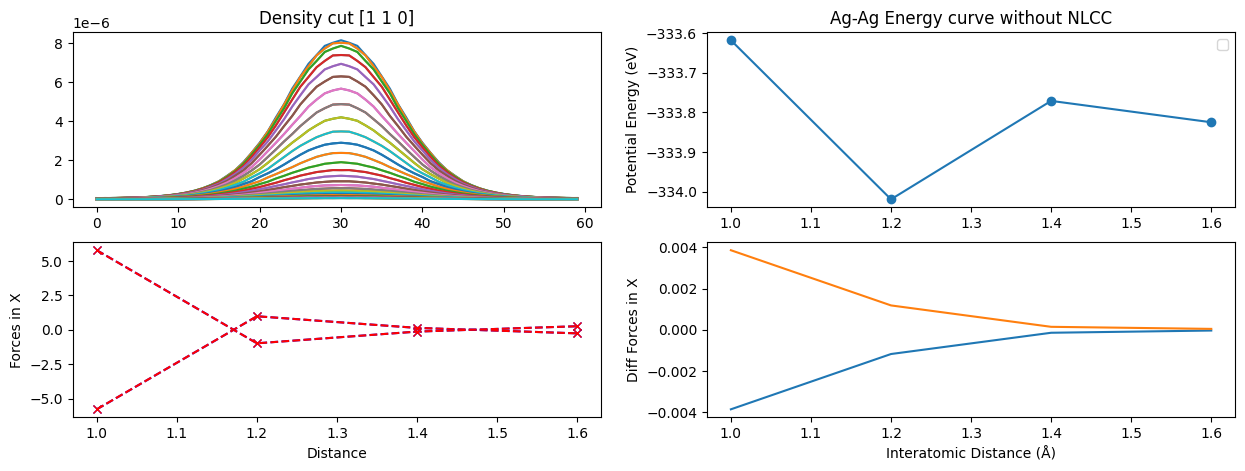

In [43]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,5))

for i in np.arange(len(rho[0][0])):
    axs[0,0].plot((rho)[0,i,:].ravel())
    
axs[0,1].scatter(alats[0:],  np.asarray(E_Ngbrv[0:]))
axs[0,1].plot(alats[0:],  np.asarray(E_Ngbrv[0:]))

axs[1,0].plot(alats[0:], atom1_x_num_N[0:], '--', label='Numerical', marker='x', color='b')
axs[1,0].plot(alats[0:], atom1_x_anl_N[0:], '--', label='Analytical', marker='x', color='r')
axs[1,0].set_ylabel('Forces in X')
axs[1,0].set_xlabel('Distance')
axs[1,0].plot(alats[0:], atom2_x_num_N[0:], '--', marker='x', color='b')
axs[1,0].plot(alats[0:], atom2_x_anl_N[0:], '--',  marker='x', color='r')

axs[1,1].plot(alats, np.asarray(atom1_x_num_N)-np.asarray(atom1_x_anl_N))
axs[1,1].plot(alats, np.asarray(atom2_x_num_N)-np.asarray(atom2_x_anl_N))
axs[1,1].set_ylabel('Diff Forces in X')
axs[1,1].set_xlabel('Distance')

plt.xlabel('Interatomic Distance (Å)')
axs[0,1].set_ylabel('Potential Energy (eV)')
axs[0,0].set_title('Density cut [1 1 0]')
axs[0,1].set_title('Ag-Ag Energy curve without NLCC')
# axs[1].set_ylim(-316,-314)


axs[0,1].legend()
plt.show()

####  GBRV

In [25]:
path_gbrv = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
PP_list_gbrv = {'Ag': path_gbrv+'ag_lda_v1.4.uspp.F.UPF'}

In [26]:
from ase import Atoms
E_gbrv = []
F_gbrv = []
V = []
nr = [10,10,10]#
opt_options = {'econv' : 1e-5}
alats_n = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]

L = 5
for alat in alats_n:
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    ions = Ions.from_ase(atoms)
    grid = DirectGrid(lattice=ions.cell, nr=nr)
    print(grid.spacings[0], grid.nr)
    PSEUDO_GBRV = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_gbrv)
    core = PSEUDO_GBRV.core_density
    if PSEUDO_GBRV.vlines_core['Ag'] is None: print('Not core') 
    PSEUDO_GBRV.local_PP()
    XC = Functional(type='XC',name='LDA', libxc=False)
    KE = Functional(type='KEDF', name='TFvW', y=0.2)
    ene_ngbrv, rho, forces= get_energy(KE, ions, PSEUDO_GBRV)
    F_gbrv.append(forces[:,0])
    E_gbrv.append(ene_ngbrv)

0.9448630629184642 [10 10 10]
setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/PP/ag_lda_v1.4.uspp.F.UPF
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -8.278184750291E+01     -8.278185E+01   5.934668E+02    1       1       1.271343E-02    
1       -4.286305689763E+02     -3.458487E+02   8.481939E+01    1       2       1.761031E-02    
2       -4.323564952796E+02     -3.725926E+00   1.275349E+01    1       3       2.325654E-02    
3       -4.332433220997E+02     -8.868268E-01   1.766314E+00    1       2       2.737498E-02    
4       -4.334599253255E+02     -2.166032E-01   7.985310E-01    1       3       3.302622E-02    
5       -4.335096747661E+02     -4.974944E-02   3.942402E-01    1       2       3.726363E-02    
6       -4.336192227751E+02     -1.095480E-01   4.658562E-01    1       3       4.270720E-02    
7       -4.336966907663E+02     -7.746799E-02   5.593211E-01    1       3       4.818058E-02    
8       -4.33758950

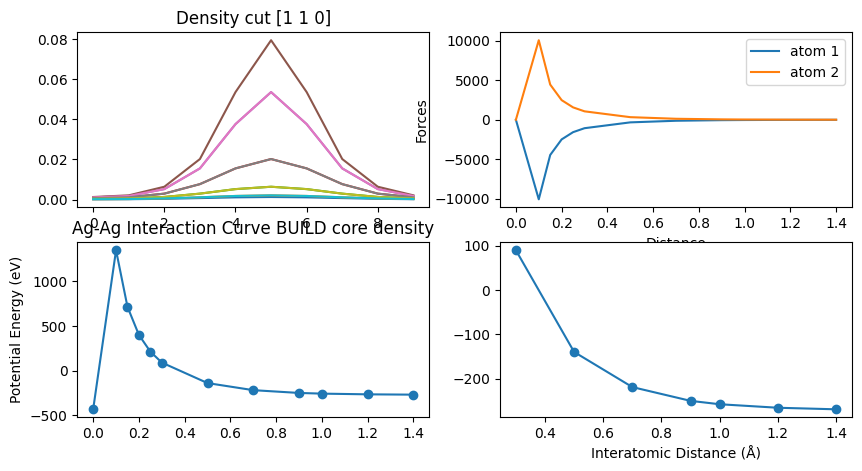

In [27]:
atom1_g = np.asarray(F_gbrv)[:,0]
atom2_g = np.asarray(F_gbrv)[:,1]
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
alats = np.linspace(0, 1.5, 10)
for i in np.arange(len(rho[0][0])):
    axs[0,0].plot((rho)[0,i,:].ravel())
axs[1,0].scatter(alats_n[0:],  np.asarray(E_gbrv[0:]))
axs[1,0].plot(alats_n[0:],  np.asarray(E_gbrv[0:]))
axs[1,1].scatter(alats_n[5:],  np.asarray(E_gbrv[5:]))
axs[1,1].plot(alats_n[5:],  np.asarray(E_gbrv[5:]))
plt.xlabel('Interatomic Distance (Å)')
axs[1,0].set_ylabel('Potential Energy (eV)')
axs[0,0].set_title('Density cut [1 1 0]')
axs[1,0].set_title('Ag-Ag Interaction Curve BUILD core density')
# axs[1].set_ylim(-316,-314)
axs[0,1].plot(alats_n, atom1_g.ravel(), label='atom 1')
axs[0,1].plot(alats_n, atom2_g.ravel(), label='atom 2')
axs[0,1].set_ylabel('Forces')
axs[0,1].set_xlabel('Distance')
axs[0,1].legend()
plt.show()